In [4]:
import strongholds
import strongholds.graphing as mplt

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider

fixed_rng = np.random.default_rng(0)

To predict where the nearest stronghold to the player will be, we can simply generate many different worlds, find the closest stronghold to each one, and plot a histogram of the results.

In [5]:
stronghold_sets = strongholds.generation_heatmap(2*10**4, rng=fixed_rng, concatenate=False)

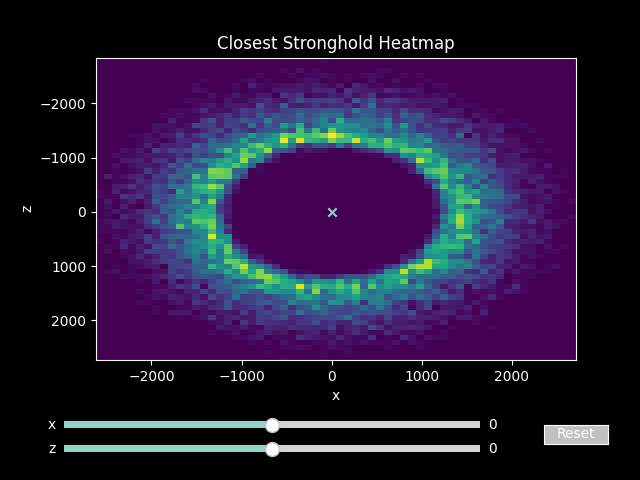

In [6]:
%matplotlib widget
fig, ax = mplt.xz_subplots(constrained_layout=False)
fig.subplots_adjust(left=0.15, bottom=0.25)

ax.set_title("Closest Stronghold Heatmap")

player = strongholds.rectpoint(0, 0)
closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)

_, _, _, hist = ax.hist2d(closest_strongholds.real,
                         closest_strongholds.imag,
                         bins=60, density=True)
player_point = ax.scatter(player.real, player.imag, marker="x", zorder=1000)

ax_x = fig.add_axes([0.1, 0.1, 0.65, 0.03])
ax_z = fig.add_axes([0.1, 0.05, 0.65, 0.03])
x_slider = Slider(ax=ax_x, label="x", valmin=-25000, valmax=25000, valinit=0)
z_slider = Slider(ax=ax_z, label="z", valmin=-25000, valmax=25000, valinit=0)

def update(val=None):
    global hist
    # update player location and closest strongholds
    player = strongholds.rectpoint(x_slider.val, z_slider.val)
    closest_strongholds = strongholds.closest_stronghold(player, stronghold_sets)

    hist.remove()
    _, _, _, hist = ax.hist2d(closest_strongholds.real,
                         closest_strongholds.imag,
                         bins=60, density=True)
    player_point.set_offsets(strongholds.math.to_xz(player))

    ax.autoscale_view()
    mplt.flip_zaxis(ax)

x_slider.on_changed(update)
z_slider.on_changed(update)

resetax = fig.add_axes((0.85, 0.075, 0.1, 0.04))
button = Button(resetax, 'Reset', color="silver", hovercolor="blue")

def resetSlider(event) -> None:
    x_slider.reset()
    z_slider.reset()

button.on_clicked(resetSlider)

mplt.flip_zaxis(ax)

As expected, stronghold generation is approximately radially symmetric, so we can perform future analyses in terms of $r$ only.